# Multiclass Hatespeech & Offensive Language Classifier

## Setup

In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
np.set_printoptions(precision = 3, suppress = True)

Import `matplotlib` and create a helper function to plot graphs:

In [6]:
def plot_graphs(hist, metric):
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

## Setup input pipeline

[3865, 68, 1089, 3340, 514] 8876


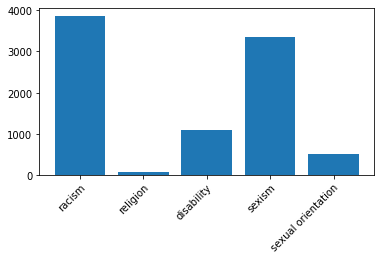

<Figure size 1152x432 with 0 Axes>

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class_count = 6
classes = ['other', 'racism', 'religion', 'disability', 'sexism', 'sexual orientation', 'toxic', 'obscene']


#
# Load the csv data.
#
def load_data_arrays():
    df_1 = pd.read_csv("datasets/1_preprocessed.csv")
    df_3 = pd.read_csv("datasets/3_preprocessed.csv")

    df_5 = pd.read_csv("datasets/5_preprocessed.csv")

    df_6 = pd.read_csv("datasets/6_preprocessed.csv")

    df = df_1.append(df_3)
    df = df.append(df_6)
    df = df.append(df_5)
    # Remove everything that isn't offensive/hate-speech
    df = df[(df['is_hatespeech'] == 1)]
    # Remove classes that use up a lot of probability mass.
    df = df[(df['class'] != 0)]
    df = df[(df['class'] != 6)]
    df = df[(df['class'] != 7)]

    return train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = df["class"])


def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    counts = [total.count(bin_val) for bin_val in bins]
    print(counts, sum(counts))
    plt.xticks(bins,
               classes[1:6],
               rotation = 45,
               rotation_mode = "anchor",
               ha = "right")

    plt.subplots_adjust(bottom = 0.3)
    plt.figure(figsize = (16, 6))
    plt.show()


train_df, test_df = load_data_arrays()

plot_data_distribution(train_df['class'].values, test_df['class'].values)

In [8]:
#
# Convert the test- and train-DataFrames to Tensorflow Datasets
#
train_labels = np.eye(class_count)[train_df['class'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype = str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(class_count)[test_df['class'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype = str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

print(test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(6,), dtype=tf.int32, name=None))


2022-01-24 23:25:00.101585: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Create the text encoder

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

## Create the model

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        mask_zero = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation = 'sigmoid'),
    tf.keras.layers.Dense(class_count, activation = 'softmax')
])

print(model.summary())

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.00075),
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 138,694
Trainable params: 138,694
Non-trai

## Train the model

In [12]:
history = model.fit(train_dataset, epochs = 5,
                    validation_data = test_dataset,
                    validation_steps = 5)

Epoch 1/5
111/111 [==============================] - 22s 174ms/step - loss: 1.3588 - accuracy: 0.3849 - val_loss: 1.1848 - val_accuracy: 0.4219
Epoch 2/5
111/111 [==============================] - 26s 238ms/step - loss: 1.0962 - accuracy: 0.5885 - val_loss: 0.8660 - val_accuracy: 0.6969
Epoch 3/5
111/111 [==============================] - 53s 477ms/step - loss: 0.6765 - accuracy: 0.7786 - val_loss: 0.6368 - val_accuracy: 0.8000
Epoch 4/5
111/111 [==============================] - 31s 280ms/step - loss: 0.5504 - accuracy: 0.8192 - val_loss: 0.5485 - val_accuracy: 0.8188
Epoch 5/5
111/111 [==============================] - 32s 294ms/step - loss: 0.4399 - accuracy: 0.8527 - val_loss: 0.5106 - val_accuracy: 0.8125


In [13]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

28/28 [==============================] - 4s 162ms/step - loss: 0.4880 - accuracy: 0.8271
Test Loss: 0.4879845380783081
Test Accuracy: 0.8271396160125732


(0.0, 1.4047135829925537)

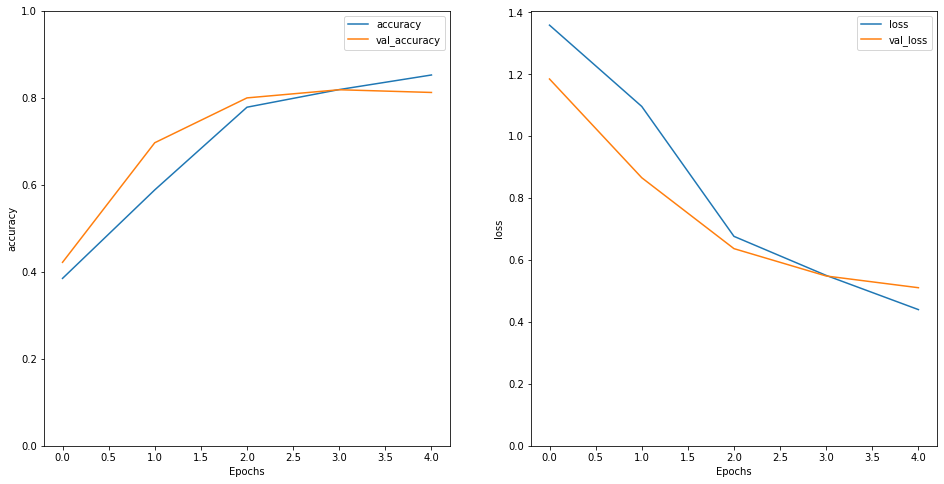

In [14]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

/Users/oliverwandschneider/dev/PycharmProjects/hatespeech_classifier/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oliverwandschneider/dev/PycharmProjects/hatespeech_classifier/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oliverwandschneider/dev/PycharmProjects/hatespeech_classifier/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

                    precision    recall  f1-score   support

            racism       0.80      0.87      0.84       773
          religion       0.00      0.00      0.00        14
        disability       0.74      0.79      0.76       218
            sexism       0.89      0.93      0.91       668
sexual orientation       0.40      0.02      0.04       103

          accuracy                           0.83      1776
         macro avg       0.57      0.52      0.51      1776
      weighted avg       0.80      0.83      0.80      1776



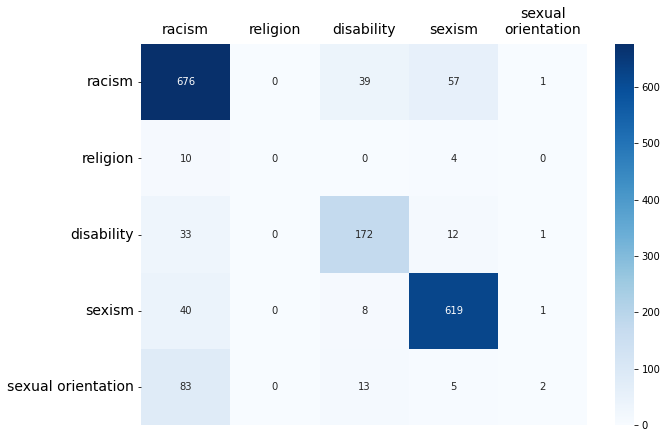

In [15]:
from sklearn.metrics import classification_report
import seaborn as sn

pred = model.predict(test_dataset)

test_data_feat = np.concatenate([x for x, y in test_dataset], axis=0)
test_data_labels = np.concatenate([y for x, y in test_dataset], axis=0)

test_data_labels = test_data_labels[:,1:]
pred = pred[:,1:]

print(classification_report(test_data_labels.argmax(axis=1),
                            pred.argmax(axis=1),
                            target_names= ['racism', 'religion', 'disability', 'sexism', 'sexual orientation']))

def plot_confusion_matrix(labels, pred, index, columns):
    conf = tf.math.confusion_matrix(labels=[np.argmax(val) for val in labels],
                                    predictions=[np.argmax(val) for val in pred])

    df_cm = pd.DataFrame(conf.numpy(), index=index, columns=columns)

    plt.figure(figsize=(10, 7))
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom=False, bottom=False, top=False,
                    labeltop=True)
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()

plot_confusion_matrix(labels=test_data_labels,
                      pred=pred,
                      index=['racism', 'religion', 'disability', 'sexism', 'sexual orientation'],
                      columns=['racism', 'religion', 'disability', 'sexism', 'sexual\norientation'])

In [16]:
model.save("models/multi_class_rnn")